# BT Detection and Classification Using CNN and Transfer Learning

## Overview
This notebook focuses on detecting and classifying brain tumors from MRI images using deep learning techniques. Brain tumors are a significant health concern with a high incidence rate and considerable diagnostic complexity. Accurate and automated detection can significantly aid in early diagnosis and treatment planning.

## Algorithms used
 Convolutional Neural Networks (CNN) and Transfer Learning (TL) with a pre-trained VGG16 model. 

## Key steps include:
- Data loading and preprocessing
- Model building using CNN and TL
- Training and evaluation of the models

# Importation of Libraries

In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import to_categorical
from tensorflow.math import  confusion_matrix
from sklearn.metrics import classification_report
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
# Upload vgg16 pretrained model to use it in the transfer learning
from tensorflow.keras.applications import VGG16
import random
random.seed(10)
import warnings
warnings.filterwarnings('ignore')


C:\Users\pc\AppData\Roaming\Python\Python39\site-packages\pandas\core\computation\expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
C:\Users\pc\AppData\Roaming\Python\Python39\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.4' currently installed).
  from pandas.core import (


# Data Loading

In [2]:
# Define the directories and image size
train_directory = 'C:/Users/pc/Pictures/Brain_tumor/Training/'
test_directory = 'C:/Users/pc/Pictures/Brain_tumor/Testing'
categories = ['glioma', 'meningioma', 'notumor', 'pituitary']  # Update with actual category names
image_size = 150

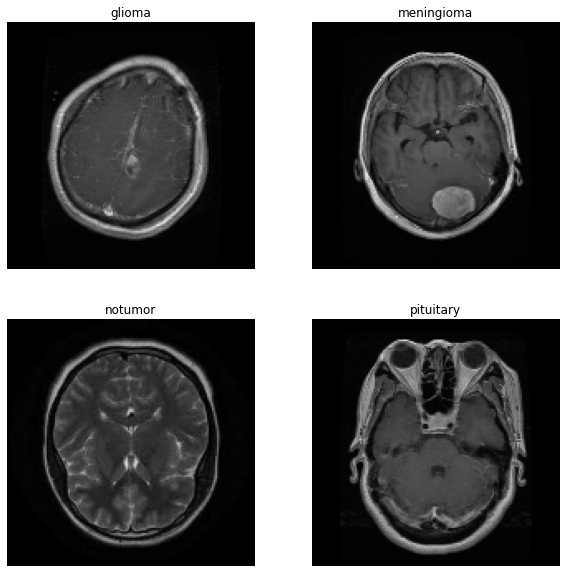

In [3]:
# Load training dataset
train_data = []
plt.figure(figsize=(10, 10))
for label in range(len(categories)):
    class_name = categories[label]
    class_path = os.path.join(train_directory, class_name)
    for image_name in os.listdir(class_path):
        image_path = os.path.join(class_path, image_name)
        image = cv2.imread(image_path)
        if image is not None:
            image_resized = cv2.resize(image, (image_size, image_size))
            train_data.append([image_resized, label])
    plt.subplot(2, 2, label + 1)
    plt.axis('off')
    plt.title(class_name)
    plt.imshow(image_resized)
plt.show()

# Load test dataset
test_data = []
for label in range(len(categories)):
    class_name = categories[label]
    class_path = os.path.join(test_directory, class_name)
    for image_name in os.listdir(class_path):
        image_path = os.path.join(class_path, image_name)
        image = cv2.imread(image_path)
        if image is not None:
            image_resized = cv2.resize(image, (image_size, image_size))
            test_data.append([image_resized, label])

# Data preprocessing

In [4]:
# Shuffle training data
random.shuffle(train_data)

In [5]:
# Split training data into features and labels
X_train = np.array([i[0] for i in train_data])
Y_train = np.array([i[1] for i in train_data])

# Split test data into features and labels
X_test = np.array([i[0] for i in test_data])
Y_test = np.array([i[1] for i in test_data])

In [6]:
# Normalize the images
X_train = X_train / 255.0
X_test = X_test / 255.0

In [7]:
# One-hot encode the labels
Y_train_cat = to_categorical(Y_train, num_classes=len(categories))
Y_test_cat = to_categorical(Y_test, num_classes=len(categories))

Unique values of labels are: [0 1 2 3]


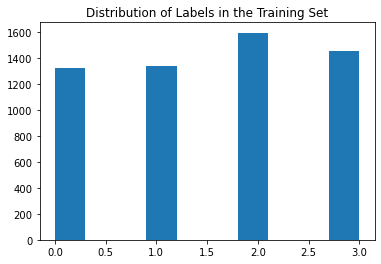

In [8]:
# Check unique values in the training label data
unique_labels = np.unique(Y_train)
print(f"Unique values of labels are: {unique_labels}")

# Distribution of labels
plt.hist(Y_train)
plt.title("Distribution of Labels in the Training Set")
plt.show()

In [9]:
# Checking for any missing values
print("Training data has missing values:", np.isnan(X_train).any())
print("Testing data has missing values:", np.isnan(X_test).any())

Training data has missing values: False
Testing data has missing values: False


# Modeling with CNN

In [10]:
# Build CNN model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(image_size, image_size, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(4, activation='softmax')
])

In [11]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 148, 148, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 74, 74, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 72, 72, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 36, 36, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 34, 34, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 17, 17, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 36992)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       4,735,104 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 4)                   │             516 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,828,868 (18.42 MB)

 Trainable params: 4,828,868 (18.42 MB)

 Non-trainable params: 0 (0.00 B)

In [12]:
# Compile model
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

In [13]:
# Train model
history = model.fit(X_train, Y_train_cat, epochs=20, validation_data=(X_test, Y_test_cat))

Epoch 1/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 88s 466ms/step - accuracy: 0.6132 - loss: 0.8997 - val_accuracy: 0.8085 - val_loss: 0.4822
Epoch 2/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 81s 454ms/step - accuracy: 0.8486 - loss: 0.3991 - val_accuracy: 0.8596 - val_loss: 0.3310
Epoch 3/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 76s 425ms/step - accuracy: 0.8991 - loss: 0.2755 - val_accuracy: 0.8879 - val_loss: 0.2790
Epoch 4/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 81s 451ms/step - accuracy: 0.9352 - loss: 0.1765 - val_accuracy: 0.9146 - val_loss: 0.2460
Epoch 5/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 85s 474ms/step - accuracy: 0.9499 - loss: 0.1461 - val_accuracy: 0.9420 - val_loss: 0.1658
Epoch 6/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 73s 406ms/step - accuracy: 0.9647 - loss: 0.1066 - val_accuracy: 0.9550 - val_loss: 0.1513
Epoch 7/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 71s 396ms/step - accuracy: 0.9722 - loss: 0.0908 - val_accuracy: 0.9504 - val_loss: 0.1359
Epoch 8/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 80s 383ms/step - accuracy: 0.9765 - loss: 0

In [14]:
loss_train, accuracy_train = model.evaluate(X_train, Y_train_cat)
loss_test, accuracy_test = model.evaluate(X_test, Y_test_cat)
print(f'Training Accuracy: {accuracy_train}, Training Loss: {loss_train}')
print(f'Testing Accuracy: {accuracy_test}, Testing Loss: {loss_test}')

179/179 ━━━━━━━━━━━━━━━━━━━━ 18s 98ms/step - accuracy: 0.9999 - loss: 0.0010
41/41 ━━━━━━━━━━━━━━━━━━━━ 4s 96ms/step - accuracy: 0.9609 - loss: 0.2195
Training Accuracy: 0.9998249411582947, Training Loss: 0.000981066026724875
Testing Accuracy: 0.9733028411865234, Testing Loss: 0.1416599154472351


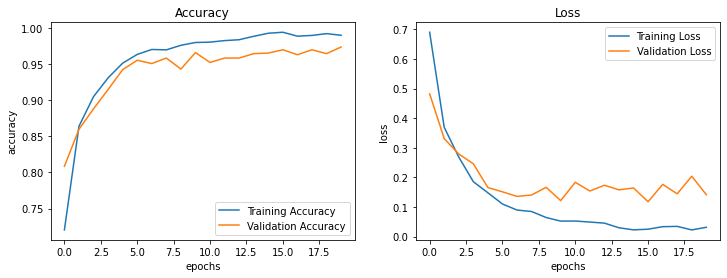

In [15]:
# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.ylabel("accuracy")
plt.xlabel("epochs")
plt.legend()
plt.title('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.ylabel("loss")
plt.xlabel("epochs")
plt.legend()
plt.title('Loss')

plt.show()

In [16]:
# Make predition on the test data
predictions = model.predict(X_test)

41/41 ━━━━━━━━━━━━━━━━━━━━ 4s 94ms/step


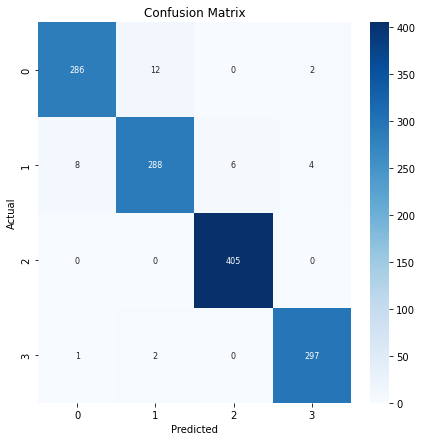

In [17]:
# Create confusion matrix
cm = confusion_matrix(Y_test, np.argmax(predictions, axis=1))
plt.figure(figsize = (7,7))
sns.heatmap(cm, annot=True, fmt='1.0f', cmap='Blues', cbar = True, annot_kws={"size": 8})
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [18]:
# Create classification report
cr = classification_report(Y_test, np.argmax(predictions, axis=1))
print(cr)

              precision    recall  f1-score   support

           0       0.97      0.95      0.96       300
           1       0.95      0.94      0.95       306
           2       0.99      1.00      0.99       405
           3       0.98      0.99      0.99       300

    accuracy                           0.97      1311
   macro avg       0.97      0.97      0.97      1311
weighted avg       0.97      0.97      0.97      1311



# Modeling with Transfer Learning

In [19]:
# Load the VGG16 model pre-trained on ImageNet, exclude top layers
vgg16_base = VGG16(weights='imagenet', include_top=False, input_shape=(image_size, image_size, 3))

In [20]:
# Unfreeze the top layers of VGG16
vgg16_base.trainable = True
for layer in vgg16_base.layers[:-4]:  # Unfreeze the last 4 layers for example
    layer.trainable = False

In [21]:
# Build the model
model_tl = Sequential([
    vgg16_base,
    Flatten(),
    Dense(256, activation='relu', kernel_regularizer=l2(0.01)),
    Dropout(0.5),
    Dense(128, activation='relu', kernel_regularizer=l2(0.01)),
    Dropout(0.5),
    Dense(4, activation='softmax')
])

In [22]:
# Print model summary
model_tl.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)                   │ (None, 4, 4, 512)           │      14,714,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 8192)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 256)                 │       2,097,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 4)                   │             516 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 16,845,508 (64.26 MB)

 Trainable params: 9,210,244 (35.13 MB)

 Non-trainable params: 7,635,264 (29.13 MB)

In [23]:
# Compile the model
model_tl.compile(optimizer=Adam(learning_rate=1e-5), loss='categorical_crossentropy', metrics=['accuracy'])

In [24]:
# Callbacks
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-7)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

In [25]:
# Train the model with data augmentation and callbacks
history_tl = model_tl.fit(
    X_train, Y_train_cat,
    epochs=20,
    validation_data=(X_test, Y_test_cat),
    callbacks=[reduce_lr, early_stopping]
)

Epoch 1/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 617s 3s/step - accuracy: 0.4097 - loss: 7.9156 - val_accuracy: 0.7628 - val_loss: 6.7568 - learning_rate: 1.0000e-05
Epoch 2/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 609s 3s/step - accuracy: 0.7262 - loss: 6.6750 - val_accuracy: 0.8070 - val_loss: 6.2019 - learning_rate: 1.0000e-05
Epoch 3/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 612s 3s/step - accuracy: 0.8157 - loss: 6.0905 - val_accuracy: 0.8459 - val_loss: 5.7471 - learning_rate: 1.0000e-05
Epoch 4/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 610s 3s/step - accuracy: 0.8407 - loss: 5.6848 - val_accuracy: 0.8604 - val_loss: 5.4185 - learning_rate: 1.0000e-05
Epoch 5/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 610s 3s/step - accuracy: 0.8800 - loss: 5.3155 - val_accuracy: 0.8940 - val_loss: 5.0876 - learning_rate: 1.0000e-05
Epoch 6/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 15577s 87s/step - accuracy: 0.8950 - loss: 5.0277 - val_accuracy: 0.9085 - val_loss: 4.8206 - learning_rate: 1.0000e-05
Epoch 7/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 518s 3s/step - 

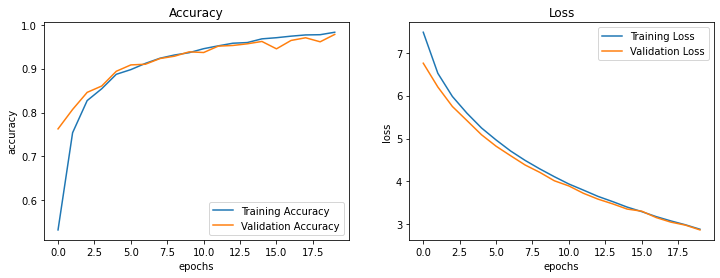

In [31]:
# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history_tl.history['accuracy'], label='Training Accuracy')
plt.plot(history_tl.history['val_accuracy'], label='Validation Accuracy')
plt.ylabel("accuracy")
plt.xlabel("epochs")
plt.legend()
plt.title('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history_tl.history['loss'], label='Training Loss')
plt.plot(history_tl.history['val_loss'], label='Validation Loss')
plt.ylabel("loss")
plt.xlabel("epochs")
plt.legend()
plt.title('Loss')

plt.show()

In [27]:
loss_train_tl, accuracy_train_tl = model_tl.evaluate(X_train, Y_train_cat)
loss_test_tl, accuracy_test_tl = model_tl.evaluate(X_test, Y_test_cat)
print(f'Training Accuracy: {accuracy_train_tl}, Training Loss: {loss_train_tl}')
print(f'Testing Accuracy: {accuracy_test_tl}, Testing Loss: {loss_test_tl}')

179/179 ━━━━━━━━━━━━━━━━━━━━ 426s 2s/step - accuracy: 0.9950 - loss: 2.8033
41/41 ━━━━━━━━━━━━━━━━━━━━ 96s 2s/step - accuracy: 0.9708 - loss: 2.8891
Training Accuracy: 0.9963235259056091, Training Loss: 2.8007724285125732
Testing Accuracy: 0.9778794646263123, Testing Loss: 2.8681111335754395


In [28]:
# Make predition on the test data
predictions_tl = model_tl.predict(X_test)

41/41 ━━━━━━━━━━━━━━━━━━━━ 95s 2s/step


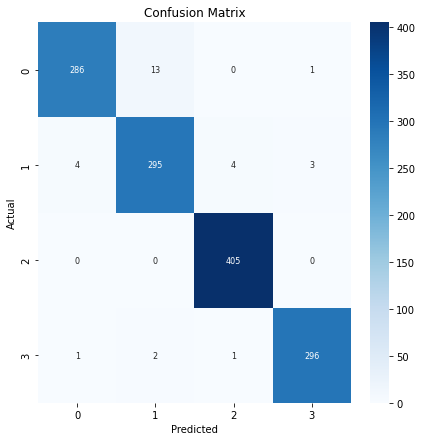

In [32]:
# Create confusion matrix
cm_tl = confusion_matrix(Y_test, np.argmax(predictions_tl, axis=1))
plt.figure(figsize = (7,7))
sns.heatmap(cm_tl, annot=True, fmt='1.0f', cmap='Blues', cbar = True, annot_kws={"size": 8})
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [33]:
# Create classification report
cr_tl = classification_report(Y_test, np.argmax(predictions_tl, axis=1))
print(cr_tl)

              precision    recall  f1-score   support

           0       0.98      0.95      0.97       300
           1       0.95      0.96      0.96       306
           2       0.99      1.00      0.99       405
           3       0.99      0.99      0.99       300

    accuracy                           0.98      1311
   macro avg       0.98      0.98      0.98      1311
weighted avg       0.98      0.98      0.98      1311

